In [1]:
import torch
from torch import functional as F
from torch import nn 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import

In [66]:
class LinearProg(nn.Module):
    def __init__(self, z, eq, ineqs):
        self.z = z
        self.eqs, self.d = self.pack(eq)
        self.ineqs = ineqs
    
    def forward(self):
        pass

    def pack(self, eq):
        d = torch.tensor([])
        eqs = torch.tensor([])
        for e in eq:
            d = torch.cat((d, torch.tensor(e[-1]).unsqueeze(0)))
            eqs = torch.cat((eqs, torch.tensor(e[:-1]).unsqueeze(-1)), -1)
        return eqs, d
    
    def solve(self, eq):
        d = torch.tensor([])
        eqs = torch.tensor([])
        for e in eq:
            d = torch.cat((d, torch.tensor(e[-1]).unsqueeze(0)))
            eqs = torch.cat((eqs, torch.tensor(e[:-1]).unsqueeze(-1)), -1)
        return eqs, d

    def region(self, arr):
        stack = torch.stack(arr, -1)
        stack = stack @ self.eqs
        stack = stack.movedim(-1, 0)

        area = []

        for ineq, plane, d in zip(self.ineqs, stack, self.d):

            match ineq:
                case '>=':
                    r = plane >= d
                case '<=':
                    r = plane <= d
                case '<':
                    r = plane < d
                case '>':
                    r = plane > d

            area.append(r)

        area = torch.stack(area)
        area = torch.all(area, 0)
        
        return area


    def draw(self, dim):

        fig = plt.figure(figsize=(10, 10))

        if dim == 2:
            s = torch.linspace(-5, 10, 600)
            xr, yr = torch.meshgrid(s, s)

            ax = fig.add_subplot()

            area = self.region([yr, xr])
            ax.imshow(area, extent=(xr.min(), xr.max(), yr.min(), yr.max()), origin='lower', cmap='Oranges', alpha=0.3) 

            x = s.unsqueeze(-1)
            y = (self.d - x @ self.eqs[:-1]) / (1e-12+self.eqs[-1])

            conv = {'<=': '≤',
                    '>=': '≥',
                    '<': '<',
                    '>': '>',
                    '=': '='}
            sub = '₀₁₂₃₄₅₆₇₈₉'
            ints = '0123456789'
            transdict = {el1: el2 for el1, el2 in zip(ints, sub)}
            
            es = []
            for l in self.eqs.mT:
                e = ''
                for i, xx in enumerate(l, 1):
                    el = f'{xx:.1f}x{transdict[str(i)]} + '
                    e += el
                es.append(e[:-3])

            labels = [f'{l} {conv[inq]} {d}' for l, inq, d in zip(es, self.ineqs, self.d)]

            x = x.expand(-1, 3).mT
            y = y.mT

            for n, data in enumerate(zip(x, y, labels)):
                xi, yi, li = data
                n = ''.join([transdict[ni] for ni in str(n)])
                ax.plot(xi, yi, label=f'g{n}(X): '+li, linewidth=2)

            plt.xlim(-5, 10)
            plt.ylim(-5, 10)

            x1, x2 = self.z.unbind()
            ax.quiver((0), (0), x1, x2, scale_units='xy', scale=1, label=f'z(X) = {x1}x₁ + {x2}x₂')

            ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0., fontsize=20)

            ax.axline([x1+x2, x2-x1], [x1-x2, x2+x1], linewidth=2, linestyle='--', color='k')

        elif dim == 3:
            s = torch.linspace(-5, 10, 100)
            reg = torch.meshgrid(s, s, s)
            ax = fig.add_subplot(projection='3d')

            area = self.region(reg)

            ax.imshow(area, extent=(s.min(), s.max(), s.min(), s.max(), s.min(), s.max()), origin='lower', cmap='Oranges', alpha=0.3) 


            x = s.unsqueeze(-1).expand(-1, 2)
            s = s.unsqueeze(-1).expand(-1, 3)
            stack = torch.stack([xr, yr], -1)
            z = (self.d - stack @ self.eqs[:-1]) / (1e-12+self.eqs[-1])
            #z = torch.all(z, 0)

            xr = xr.unsqueeze(-1).expand([-1, -1, 3])
            yr = yr.unsqueeze(-1).expand([-1, -1, 3])
            #ax.imshow(area.int(), extent=(xr.min(), xr.max(), yr.min(), yr.max(), zr.min(), zr.max()), origin='lower', cmap='Oranges', alpha=0.3)
            ax.scatter(xr.flatten(), yr.flatten(), z.flatten(), alpha=0.2) 

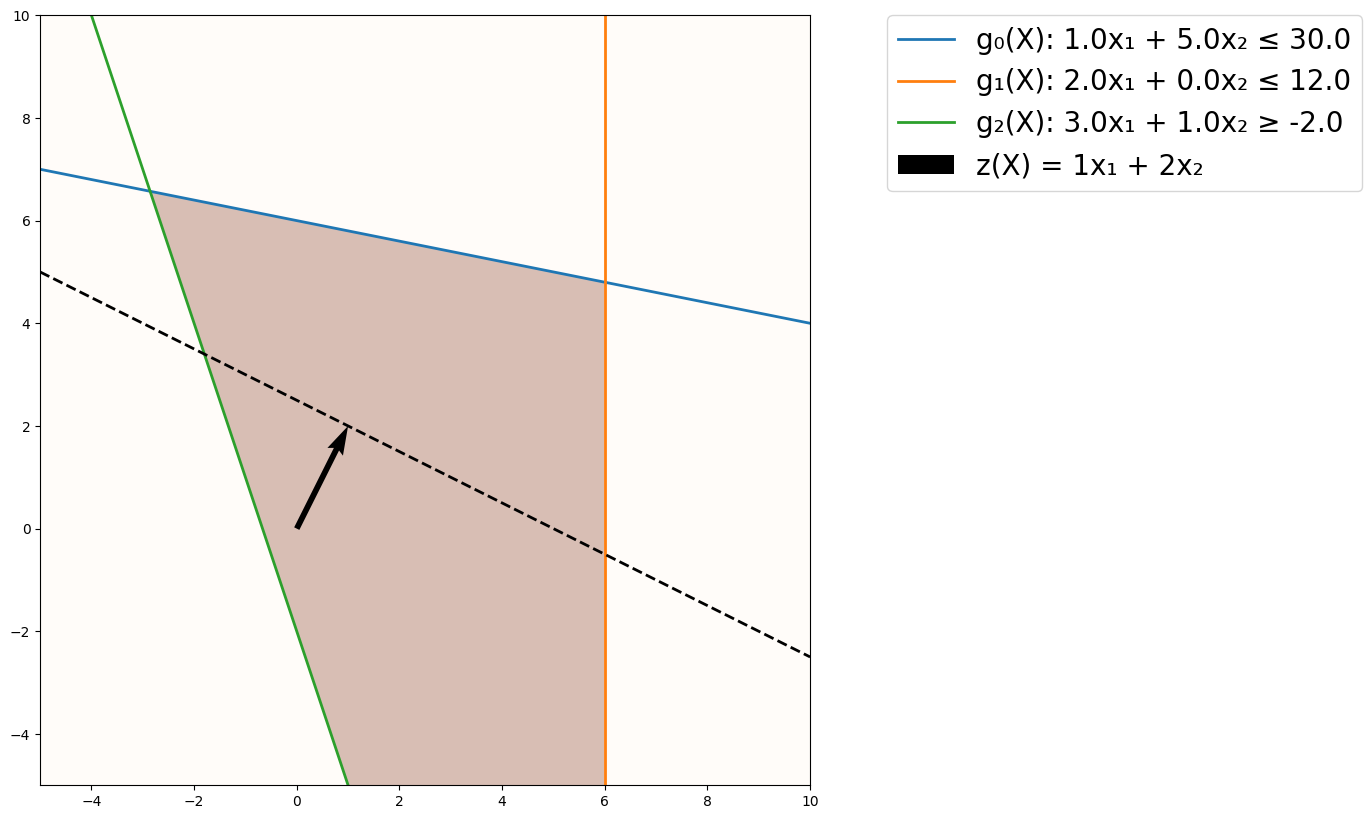

In [67]:
z = torch.tensor([1, 2])
eq = ((1, 5, 30), (2, 0, 12), (3, 1, -2))
ineq = ('<=', '<=', '>=')
pr = LinearProg(z, eq, ineq)

pr.draw(2)